## Loss Landscape Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

#### Load Iris Data

In [2]:
df = pd.read_table('data/iris.data.txt', sep=',', 
                   names=['sepal length', 'sepal width', 'petal length', 'petal width', 'label'])
df = df[df['label'].isin(['Iris-setosa', 'Iris-versicolor'])]   # only keep 2 classes
df = df.reset_index(drop=True)
print('Dimensions:', df.shape)
df.head()

Dimensions: (100, 5)


,sepal length,sepal width,petal length,petal width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### PCA

Reduce from 4 features to 2 features, so that we can visualize the 2 reduced features and loss in a 3D plot.

In [3]:
X = df.drop('label', axis=1)
y = df['label']
pca = PCA(n_components=2)
X = pca.fit_transform(X)
df = pd.DataFrame(X, columns=['X1', 'X2'])
df['label'] = y
df.head()

,X1,X2,label
0,-1.654413,0.206607,Iris-setosa
1,-1.635095,-0.298835,Iris-setosa
2,-1.820375,-0.271417,Iris-setosa
3,-1.662073,-0.430217,Iris-setosa
4,-1.703589,0.215741,Iris-setosa


Text(0,0.5,'X2')

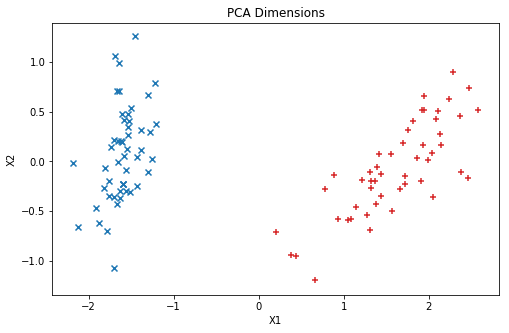

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(df['X1'][df['label'] == 'Iris-setosa'], df['X2'][df['label'] == 'Iris-setosa'], marker='x', color='C0')
plt.scatter(df['X1'][df['label'] == 'Iris-versicolor'], df['X2'][df['label'] == 'Iris-versicolor'], marker='+', color='C3')
plt.title('PCA Dimensions')
plt.xlabel('X1')
plt.ylabel('X2')

#### Logistic Regression

In [5]:
class LogisticRegression():
  def loss(self, X, y, theta):
    YX = X * y[:, None]
    hy = YX @ theta
    loss = np.log(1 + np.exp(-hy)).mean()
    error = (hy <= 0).mean()
    return loss, error

  def gradient(self, X, y, theta):
    YX = X * y[:, None]
    m = X.shape[0]
    gradient = -YX.T @ (1 / (1 + np.exp(YX @ theta))) / m
    return gradient

  def gradient_descent(self, X, y, alpha, iters):
    m, n = X.shape
    theta = np.zeros(n)
    loss, err = np.zeros(iters), np.zeros(iters)
    grads = np.zeros((iters, X.shape[1]))

    for t in range(iters):
      loss[t], err[t] = self.loss(X, y, theta)
      # print(self.gradient(X, y, theta))

      grads[t] = self.gradient(X, y, theta)
      theta -= alpha * grads[t]
      # print("At step {}: theta={}, loss={}, err={}, grad={}".
      #       format(t, theta, loss[t], err[t], grads[t]))
    return theta, loss, err, grads

In [7]:
X = df[['X1', 'X2']].as_matrix()
y = ((df['label'] == 'Iris-setosa') * 2 - 1).as_matrix()   # convert to 1 / -1 labels

In [8]:
# define a model
model = LogisticRegression()
alpha = 1.0
theta, loss, err, grads = model.gradient_descent(X, y, alpha, 5000)
print("Converged theta = {}".format(theta))

Converged theta = [-6.55950304  3.64188857]


Text(0,0.5,'X2')

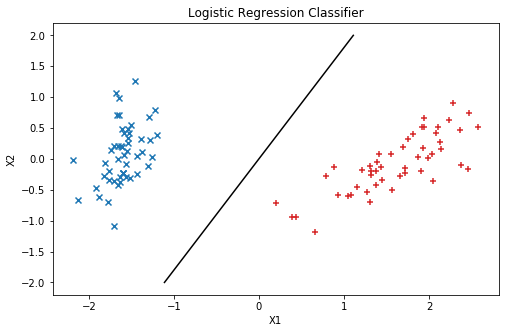

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(df['X1'][df['label'] == 'Iris-setosa'], df['X2'][df['label'] == 'Iris-setosa'], marker='x', color='C0')
plt.scatter(df['X1'][df['label'] == 'Iris-versicolor'], df['X2'][df['label'] == 'Iris-versicolor'], marker='+', color='C3')
line_x2_points = np.linspace(-2, 2)
line_x1_points = -theta[1]/theta[0] * line_x2_points
plt.plot(line_x1_points, line_x2_points, 'k-')
plt.title('Logistic Regression Classifier')
plt.xlabel('X1')
plt.ylabel('X2')

#### Visualizing loss

Visualizing loss over epochs.

Text(0,0.5,'Loss')

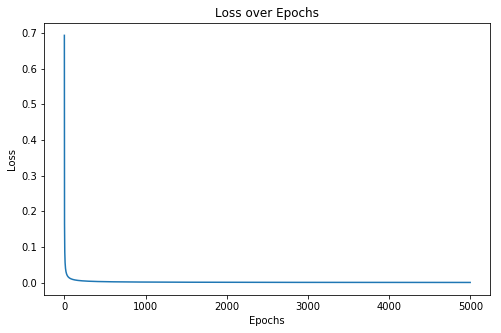

In [11]:
plt.figure(figsize=(8,5))
epochs = range(5000)
plt.plot(epochs, loss)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

The optimal theta from gradient descent.

In [12]:
theta

array([-6.55950304,  3.64188857])

Creating a grid of theta values (centered at optimal theta) for evaluating loss.

Text(0,0.5,'theta1')

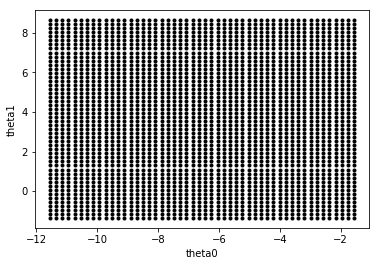

In [13]:
theta_0_range = np.linspace(theta[0] - 5, theta[0] + 5, 50)
theta_1_range = np.linspace(theta[1] - 5, theta[1] + 5, 50)
theta_0, theta_1 = np.meshgrid(theta_0_range, theta_1_range)
plt.plot(theta_0, theta_1, '.', color='k')
plt.xlabel('theta0')
plt.ylabel('theta1')

Visualizing the loss landscape with a contour plot.

Text(0,0.5,'theta1')

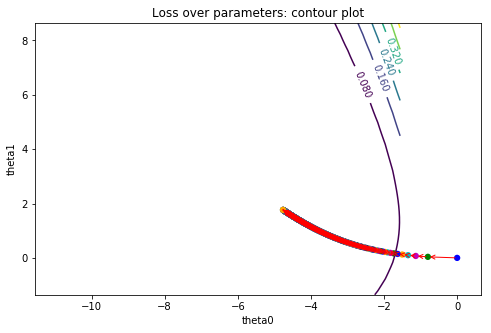

In [14]:
  grid_rows, grid_cols = theta_0.shape
  loss = np.zeros((grid_rows, grid_cols))
  for i in range(grid_rows):
    for j in range(grid_cols):
      theta_0_ij = theta_0[i, j]
      theta_1_ij = theta_1[i, j]
      theta = np.array([theta_0_ij, theta_1_ij])
      loss[i, j] = model.loss(X, y, theta)[0]

  # perform gradient
  n_step = 500
  theta_ = [np.array((0., 0.))]
  loss_ = [model.loss(X, y, theta_[-1])[0]]  # also return error
  for j in range(n_step-1):
    prev_theta = theta_[-1]

    # update now based on the closed form formula
    current_grad = model.gradient(X, y, prev_theta)
    current_theta = prev_theta - alpha * current_grad

    theta_.append(current_theta)
    loss_.append(model.loss(X, y, theta_[-1])[0])
    # print("Step {}, prev_theta={}, current_theta={}, loss={}".
    #       format(j, prev_theta, current_theta, loss_[-1]))

  plt.figure(figsize=(8, 5))
  contour = plt.contour(theta_0, theta_1, loss)

  # draw gradient
  for j in range(1, n_step):
    plt.annotate('', xy=theta_[j], xytext=theta_[j-1],
                 arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                 va='center', ha='center')

  # more decoration
  colors = ['b', 'g', 'm', 'c', 'orange']
  plt.scatter(*zip(*theta_), c=colors, s=40, lw=0)

  plt.clabel(contour, inline=1, fontsize=10)
  plt.title('Loss over parameters: contour plot')
  plt.xlabel('theta0')
  plt.ylabel('theta1')

Visualizing the loss landscape with a 3D plot.

Good matplotlib 3D plotting reference: https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [16]:
# https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot

# 3D plot
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
      FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
      self._verts3d = xs, ys, zs

    def draw(self, renderer):
      xs3d, ys3d, zs3d = self._verts3d
      xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
      self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
      FancyArrowPatch.draw(self, renderer)

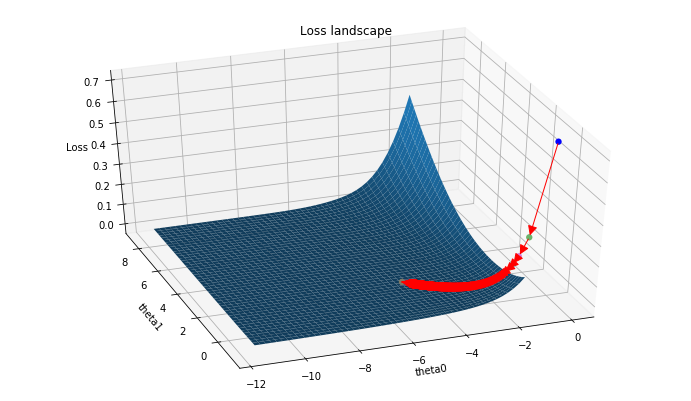

In [19]:
  fig = plt.figure(figsize=(12, 7))
  ax = plt.axes(projection='3d')
  ax.plot_surface(theta_0, theta_1, loss)

  # draw gradient
  for j in range(1, n_step):
    a = Arrow3D([theta_[j-1][0], theta_[j][0]],
                [theta_[j-1][1], theta_[j][1]],
                [loss_[j-1], loss_[j]],
                mutation_scale=20,
                lw=1, arrowstyle="-|>", color='r')
    ax.add_artist(a)

  # more decoration
  first_theta_, second_theta_ = zip(*theta_)
  ax.scatter(first_theta_, second_theta_, loss_,
             c=colors*100,
             s=40, lw=0,
             zorder=1)


  ax.set_title('Loss landscape')
  ax.set_xlabel('theta0')
  ax.set_ylabel('theta1')
  ax.set_zlabel('Loss')
  ax.view_init(40, 250)

  plt.draw()